# Определение возраста покупателей

**Описание проекта**<br>
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:<br>
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.<br>

**План выполнения проекта**<br>
1. Провести исследовательский анализ набора фотографий,
2. Подготовить данные к обучению,
3. Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.shape

(7591, 2)

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

В нашей выборки 7591 фотография разрешением 224 х 224 пикселя.

<AxesSubplot:ylabel='Frequency'>

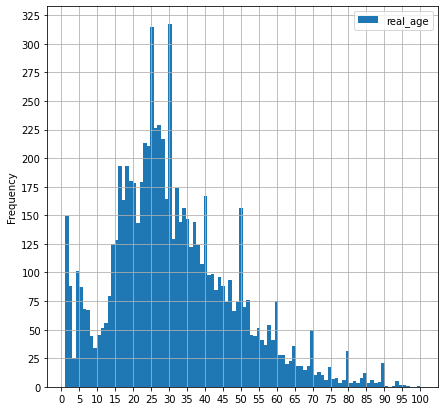

In [14]:
labels.plot(
    kind='hist',
    bins=100,
    xticks=np.arange(0,105,5),
    yticks=np.arange(0,330,25),
    grid=True,
    figsize= (7,7)
)

<AxesSubplot:ylabel='Frequency'>

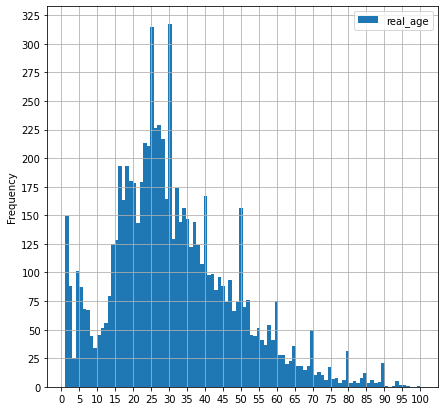

In [65]:
labels.plot(
    kind='hist',
    bins=100,
    xticks=np.arange(0,105,5),
    yticks=np.arange(0,350,25),
    grid=True,
    figsize= (7,7)
)

In [37]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<AxesSubplot:>

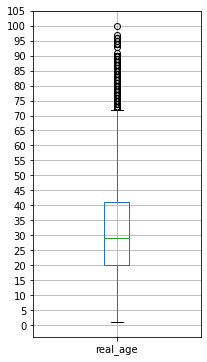

In [73]:
labels.plot(kind='box', yticks=np.arange(0, 110, 5), grid=True, figsize=(3,6))

Возраст покупателей сконцентрирован в интервале от 20 до 40 лет.<br>
В выборки попали как новорожденные, так и люди пожилого возраста.<br>
Исходя из гистограммы, покупателей возрастом до 10 лет, можно отнести к отдельной категории.<br>
Имеются выбросы в виде отдельных возрастов и людей возрастом свыше 72 лет.

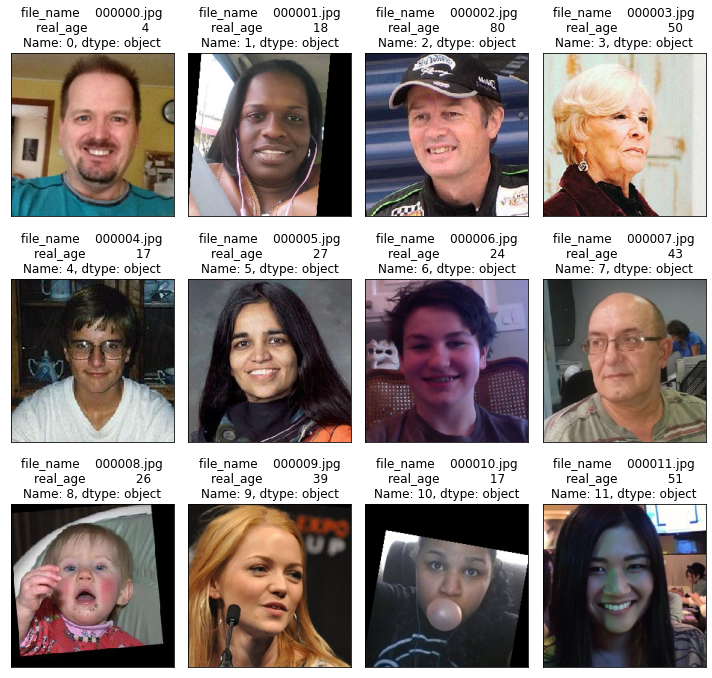

In [56]:
# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title(str(labels.iloc[i][:2]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Визуально присутсвует неправильная разметка данных. Перепроверим.

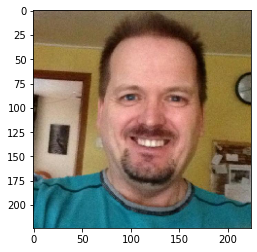

In [49]:
plt.imshow(features[0])

In [48]:
labels.head(12)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Действительно, присутсвуют фотографии с неправильной разметкой. <br>
На некоторых фотографиях лица людей находятся в тени, засвечены, прикрыты различными предметами.<br> 
Такие аспекты могут отрицательно сказаться на качестве модели. <br>
Ориентация людей на фото нормальная: отсутствуют перевернутые портреты. <br>


**Вывод:** <br>
Проведен исследовательский анализ данных. Даны краткие интерпритации результатов.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
# ---------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# =======================================================================


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255
    )

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        batch_size=16,
        seed=12345)

    return train_gen_flow
# ---------------------------------------------------------------------


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=16,
        subset='validation',
        seed=12345)

    return test_gen_flow
# ---------------------------------------------------------------------


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model
# ---------------------------------------------------------------------


def train_model(
    model, train_data, test_data,
    batch_size=None,
    epochs=5,
    steps_per_epoch=None,
    validation_steps=None
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-06-29 21:15:48.387964: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-29 21:15:48.679067: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
Epoch 2/5
356/356 - 47s - loss: 194.0144 - mae: 10.2317 - val_loss: 535.5339 - val_mae: 17.8508
356/356 - 38s - loss: 81.8526 - mae: 6.8712 - val_loss: 137.1386 - val_mae: 8.5529
Epoch 3/5
356/356 - 38s - loss: 60.1981 - mae: 5.8729 - val_loss: 73.2776 - val_mae: 6.4207
Epoch 4/5
356/356 - 38s - loss: 41.9434 - mae: 4.9537 - val_loss: 92.5943 - val_mae: 7.5372
Epoch 5/5
356/356 - 38s - loss: 32.6627 - mae: 4.3781 - val_loss: 65.0903 - val_mae: 5.9926
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 65.0903 - mae: 5.9926
Test MAE: 5.9926
```

**Вывод:** <br>
Модель обучена. МАЕ модели 6

## Анализ обученной модели

- Модель нейронной сети построена на архитектуре ResNet50 без заморозки слоев. Выходной слой состоит из 1 одного нейрона с функцией активации 'relu'.
- Модель обладает высоким качеством предсказания. Расхождение между реальным и предсказанным возрастом составляет 6 лет. Такая разница позволяет с высокой степенью точности, отнести человека к возрастным категориям, применяемые магазином к своим покпателям.
- 18 лет попадает в диапозон 12 - 24 года ( [-MAE;+MAE] ). Это диапозон, в который попадет 18-летний покупатель при прогнозировании его возраста. С таким диапозоном предсказаний, количество алкоголя проданного несовершеннолетним покупателям, будет сведенно к минимуму.